# Differentiating through a continuous-time Kalman-Filter

In this example we will be optimizing the parameters of a Kalman-Filter such that faster convergence of the estimated state towards the true state can be achieved. 

We will first write down the Kalman-Filter equations in continuous-time and use diffrax to handle the numerical integration. 

Finally, if we assume that we do in fact know the true state trajectory, we can optimize through the integration to increase the performance of our Kalman-Filter.

In [70]:
from types import SimpleNamespace
from typing import Optional, Union
import functools as ft 

import jax 
import jax.numpy as jnp 
import jax.random as jrand
import jax.tree_util as jtu 
import optax 

import equinox as eqx
import diffrax as dfx
import matplotlib.pyplot as plt 


class LTISystem(eqx.Module):
    A: jnp.ndarray
    B: jnp.ndarray
    C: jnp.ndarray

    def __iter__(self):
        return (x for x in (self.A, self.B, self.C))


def harmonic_oscillator(damping: float = 0.0, time_scaling: float = 1.0) -> LTISystem:
    """Returns a 2nd order linear time-invariant system in continuous-time state-space 
    representation.

    Args:
        damping (float, optional): Unitless damping parameter. Defaults to 0.0.
        time_scaling (float, optional): Unitless scaling of time. Defaults to 1.0.

    Returns:
        LTISystem
    """
    A = jnp.array([[0.0, time_scaling], [-time_scaling, -2*damping]])
    B = jnp.array([[0.0], [1.0]])
    C = jnp.array([[0.0, 1.0]])
    return LTISystem(A,B,C)


def _interpolate_us(ts, us, B):
    if us:
        u_t = dfx.LinearInterpolation(ts=ts, ys=us)
    else:
        m = B.shape[-1]
        u_t = SimpleNamespace(evaluate=lambda t: jnp.zeros((m,)))
    return u_t 


def _diffeqsolve(
    rhs, 
    ts: jnp.ndarray,
    y0: jnp.ndarray,
    solver: dfx.AbstractSolver = dfx.Dopri5(),
    stepsize_controller: dfx.AbstractStepSizeController = dfx.ConstantStepSize(),
    dt0: float = 0.01
    ) -> jnp.ndarray:
    return dfx.diffeqsolve(
            dfx.ODETerm(rhs), 
            solver=solver, 
            stepsize_controller=stepsize_controller,
            t0=ts[0], t1=ts[-1], y0=y0, dt0=dt0,
            saveat=dfx.SaveAt(ts=ts),
        ).ys


def simulate_lti_system(
        sys: LTISystem, 
        y0: jnp.ndarray, 
        ts: jnp.ndarray,
        us: Optional[jnp.ndarray] = None,
        std_measurement_noise: float = 0.0, 
        key=jrand.PRNGKey(1,)
        ):
    """ Utility function for forward-simulation of `LTISystem`.
    """

    u_t = _interpolate_us(ts, us, sys.B)

    def rhs(t,y,args):
        return sys.A@y + sys.B@u_t.evaluate(t)

    xs = _diffeqsolve(rhs, ts, y0)

    # noisy measurements
    ys = xs@sys.C.transpose() 
    ys = ys + jrand.normal(key, shape=ys.shape)*std_measurement_noise

    return xs, ys 


class KalmanFilter(eqx.Module):
    """Continuous-time Kalman Filter implementation

    Ref: 
        [1] Optimal and robust estimation. 2nd edition. Page 154.
        https://lewisgroup.uta.edu/ee5322/lectures/CTKalmanFilterNew.pdf
    """

    sys: LTISystem
    x0: jnp.ndarray
    P0: jnp.ndarray
    Q: jnp.ndarray
    R: jnp.ndarray

    def __call__(self, ts, ys, us: Optional[jnp.ndarray] = None):
        
        A,B,C = self.sys 

        y_t = dfx.LinearInterpolation(ts=ts, ys=ys)
        u_t = _interpolate_us(ts, us, B)

        n = len(self.x0)
        y0 = jnp.concatenate((self.x0, self.P0.reshape(n**2)))

        def rhs(t,y,args):
            x, P = y[:n], y[n:].reshape((n,n))

            # eq 3.22 of Ref [1]
            K = P@C.transpose()@jnp.linalg.inv(self.R)

            # eq 3.21 of Ref [1]
            dPdt = A@P + P@A.transpose() + self.Q \
                - P@C.transpose()@jnp.linalg.inv(self.R)@C@P
            
            # eq 3.23 of Ref [1]
            dxdt = A@x + B@u_t.evaluate(t) + \
                K@(y_t.evaluate(t) - C@x)

            return jnp.concatenate((dxdt, dPdt.reshape(n**2)))

        return _diffeqsolve(rhs, ts, y0)[:, :n]


In [93]:
# system 1 generates data
sys1 = harmonic_oscillator(0.3)
# system 2 is our model for system 1, it's not perfect
sys2 = harmonic_oscillator(0.7)

# evaluate at these timepoints
ts = jnp.arange(0, 5.0, 0.01)

# the initial state of our data generating system
x0_system = jnp.array([1.0, 0.0])
# we simulate the system, and add some noise to the measurements `ys`
xs, ys = simulate_lti_system(sys1, x0_system, ts, std_measurement_noise=1.0)

# Q weighs how much we trust our model of the system
# R weighs how much we trust in the measurements of the system
# *large* Q/R imply *low* trust
Q = jnp.diag(jnp.ones((2,)))*0.1
R = jnp.diag(jnp.ones((1,)))

# this is our initial state guess, it's not perfect
x0_kmf = jnp.array([0.0, 0.0])
# P0 weighs how much we trust our initial guess
# clearly not too much
P0 = Q*100

# putting it all together
kmf = KalmanFilter(sys2, x0_kmf, P0, Q, R)

Let's see our Kalman-filter at work. 

Over time the state estimate converges to the true state. 

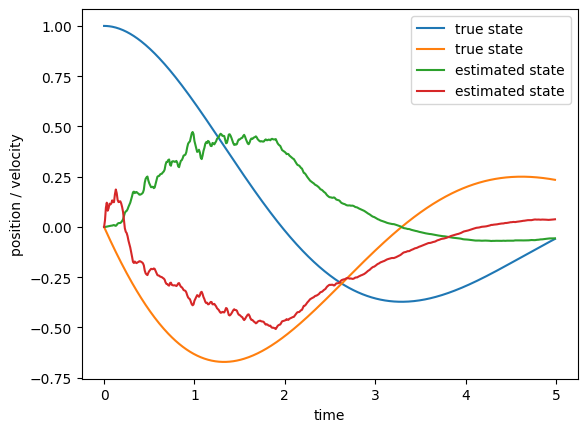

In [87]:
xhats = kmf(ts, ys)
plt.plot(ts, xs, label="true state")
plt.plot(ts, xhats, label="estimated state")
plt.xlabel("time")
plt.ylabel("position / velocity")
plt.legend()

However, the Kalman-Filter has parameters (R/Q) itself. Assuming the MSE between estimated state and true state as metric. Is there a better choice for R/Q?

In [88]:
# gradients should only be able to change Q/R parameters
# *not* the model (well at least not in this example :) 
filter_spec = jtu.tree_map(lambda arr: False, kmf)
filter_spec = eqx.tree_at(lambda tree: (tree.Q, tree.R), filter_spec, replace=(True, True))

@eqx.filter_jit 
@ft.partial(eqx.filter_value_and_grad, arg=filter_spec)
def loss_fn(kmf, ts, ys, xs):
    xhats = kmf(ts, ys)
    return jnp.mean((xs-xhats)**2)

In [89]:
opt = optax.adam(1e-2)
opt_state = opt.init(kmf)

for step in range(100):
    value, grads = loss_fn(kmf, ts, ys, xs)
    if step % 10 == 0:
        print("Current MSE: ", value)
    updates, opt_state = opt.update(grads, opt_state)
    kmf = eqx.apply_updates(kmf, updates)

Current MSE:  0.10257154
Current MSE:  0.09800264
Current MSE:  0.09304534
Current MSE:  0.08753822
Current MSE:  0.08122823
Current MSE:  0.073712476
Current MSE:  0.06441847
Current MSE:  0.053475548
Current MSE:  0.04611182
Current MSE:  0.03786329


Clearly, there exists a different set of parameters that leads to a lower MSE and (in this sense) a higher performance Kalman-Filter!

In [91]:
kmf.Q

DeviceArray([[-0.44275695,  1.3142775 ],
             [-1.186767  ,  0.91202587]], dtype=float32)

In [92]:
kmf.R

DeviceArray([[0.14836906]], dtype=float32)

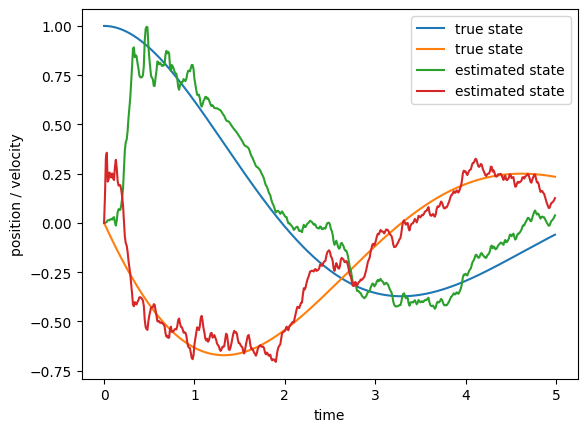

In [90]:
xhats = kmf(ts, ys)

plt.plot(ts, xs, label="true state")
plt.plot(ts, xhats, label="estimated state")
plt.xlabel("time")
plt.ylabel("position / velocity")
plt.legend()

We can see that the MSE is smaller. The reason is that we trust our measurements more as there is quite a big modeling error.

We can see this nicely through the added noise in our state estimate. Remember that the measurements are quite noisy after all.

Well, that's it. Thanks! :)